In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import torchvision.models as models
import torch.nn as nn

import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
from pathlib import Path

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os

os.chdir(r'C:\Users\Gwool\Documents\Python Scripts\Image Mkt')

IMAGE_DIR      = './images/gender/train'
IMAGE_DIR_TEST = './images/gender/test'
VALID_SPLIT    = 0.2
IMAGE_SIZE     = 224 
BATCH_SIZE     = 15
NUM_WORKERS    = 4 

NUM_CLASSES    = 2
NUM_EPOCHS     = 25
pretrained     = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Functions

In [9]:
def get_train_transform(IMAGE_SIZE, pretrained=True):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return train_transform


def get_valid_transform(IMAGE_SIZE, pretrained=True):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return valid_transform

def normalize_transform(pretrained=True):
    if pretrained: # Normalization for pre-trained weights.
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    else: # Normalization when training from scratch.
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    return normalize

In [2]:
def get_datasets(pretrained=True, apply_class_weights=False):
    dataset = datasets.ImageFolder(IMAGE_DIR, transform=(get_train_transform(IMAGE_SIZE, pretrained)))
    if apply_class_weights:
        class_counts = [0] * len(dataset.classes)
        for _, label in dataset.imgs:
            class_counts[label] += 1
        class_weights = [1.0 / count for count in class_counts]
        weights = torch.FloatTensor(class_weights)
        sampler = WeightedRandomSampler(weights, len(dataset), replacement=True)
    else:
        sampler = None

    dataset_size = len(dataset)
    valid_size = int(VALID_SPLIT * dataset_size)

    indices = torch.randperm(len(dataset)).tolist()
    dataset_train = Subset(dataset, indices[:-valid_size])
    dataset_valid = Subset(dataset, indices[-valid_size:])

    # Test data set
    dataset_test = datasets.ImageFolder(IMAGE_DIR_TEST, transform=get_valid_transform(IMAGE_SIZE, pretrained))

    return dataset_train, dataset_valid, dataset_test, dataset.classes, dataset.class_to_idx, sampler

def get_data_loaders(dataset_train, dataset_valid, dataset_test, sampler=None):
    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=(sampler is None), sampler=sampler, num_workers=NUM_WORKERS)
    valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    return train_loader, valid_loader, test_loader


In [3]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, fine_tune=True, pretrained=True):
        super(CustomEfficientNet, self).__init__()
        # Load the pretrained EfficientNetB0 model
        self.base_model = models.efficientnet_b0(pretrained=pretrained)
        
        # Remove the last classification layer (top layer)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Freeze the weights of the pretrained layers if fine_tune is False
        if not fine_tune:
            for param in self.base_model.parameters():
                param.requires_grad = False
        
        # Add custom top layers
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes) 
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [4]:
def f1_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    tp = (y_true * y_pred).sum(dim=0)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0)
    fp = ((1 - y_true) * y_pred).sum(dim=0)
    fn = (y_true * (1 - y_pred)).sum(dim=0)
    
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    macro_f1 = f1.mean()
    
    return macro_f1

def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)

        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()

        optimizer.step()
    

    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / (counter * trainloader.batch_size))

    return epoch_loss, epoch_acc


def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [5]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in tqdm(dataloader, total=len(dataloader)):
            images, _ = data 
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

def get_predictions_and_confusion_matrix(model, dataloader):
    model.eval()
    
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    confusion_mat = confusion_matrix(all_labels, all_predictions)
    
    return all_predictions, all_labels, confusion_mat


In [6]:
def load_model(section, version=None, device='cpu'):
    version = str(version)
    temp_path = Path(f'models/{section}')

    if version is not None:
        model_path = temp_path / f'model_{section}_V{version}.pth'
    else:
        model_path = temp_path / f'model_{section}.pth'

    with open(temp_path / 'classes_dict.pkl', 'rb') as f:
        class_dict = pickle.load(f)

    temp_model = CustomEfficientNet(num_classes=len(class_dict.keys())).to(device)
    temp_model.load_state_dict(torch.load(model_path, map_location=device))
    temp_model.eval()

    return temp_model, class_dict

##### Model

Data Loaders

In [10]:
dataset_train, dataset_valid, dataset_test, classes, classes_dict, sampler = get_datasets(pretrained=True, apply_class_weights=False)
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test, sampler)

# Número de clases
NUM_CLASSES = len(classes)

In [ ]:
model = CustomEfficientNet(num_classes = NUM_CLASSES).to(device)

c:\Users\Gwool\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gwool\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train

In [ ]:
NUM_EPOCHS = 45

torch.manual_seed(42)

In [ ]:
best_valid_loss = float('inf')
train_loss, valid_loss = [], []
train_acc , valid_acc  = [], []

for epoch in range(NUM_EPOCHS):
    
    print(f"[INFO]: Epoch {epoch+1} of {NUM_EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(   model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc. append(train_epoch_acc )
    valid_acc. append(valid_epoch_acc )
    
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

    if valid_epoch_loss < best_valid_loss:
        best_valid_loss = valid_epoch_loss
        save_dir = Path(f'models/gender')
        save_dir.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), save_dir / 'model_gender_V1.pth')

[INFO]: Epoch 1 of 45
Training


100%|██████████| 1029/1029 [01:50<00:00,  9.30it/s]


Validation


100%|██████████| 258/258 [00:17<00:00, 14.37it/s]


Training loss: 0.300, training acc: 87.742
Validation loss: 0.290, validation acc: 88.077
--------------------------------------------------
[INFO]: Epoch 2 of 45
Training


 25%|██▍       | 253/1029 [00:27<01:36,  8.02it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F4779C3700>
Traceback (most recent call last):
  File "c:\Users\Gwool\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\Gwool\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
100%|██████████| 1029/1029 [01:50<00:00,  9.28it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 15.45it/s]


Training loss: 0.512, training acc: 78.581
Validation loss: 1.076, validation acc: 81.960
--------------------------------------------------
[INFO]: Epoch 3 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.45it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 15.41it/s]


Training loss: 0.371, training acc: 83.900
Validation loss: 0.309, validation acc: 87.273
--------------------------------------------------
[INFO]: Epoch 4 of 45
Training


100%|██████████| 1029/1029 [01:49<00:00,  9.38it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 15.56it/s]


Training loss: 0.376, training acc: 84.321
Validation loss: 0.423, validation acc: 83.359
--------------------------------------------------
[INFO]: Epoch 5 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.45it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.03it/s]


Training loss: 0.359, training acc: 84.911
Validation loss: 0.302, validation acc: 86.936
--------------------------------------------------
[INFO]: Epoch 6 of 45
Training


100%|██████████| 1029/1029 [01:50<00:00,  9.34it/s]


Validation


100%|██████████| 258/258 [00:17<00:00, 14.93it/s]


Training loss: 0.320, training acc: 86.731
Validation loss: 0.420, validation acc: 84.655
--------------------------------------------------
[INFO]: Epoch 7 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.99it/s]


Training loss: 0.296, training acc: 87.839
Validation loss: 0.303, validation acc: 88.777
--------------------------------------------------
[INFO]: Epoch 8 of 45
Training


100%|██████████| 1029/1029 [01:49<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:14<00:00, 17.26it/s]


Training loss: 0.297, training acc: 88.176
Validation loss: 0.296, validation acc: 87.455
--------------------------------------------------
[INFO]: Epoch 9 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.45it/s]


Validation


100%|██████████| 258/258 [00:14<00:00, 17.36it/s]


Training loss: 0.307, training acc: 87.937
Validation loss: 0.421, validation acc: 80.949
--------------------------------------------------
[INFO]: Epoch 10 of 45
Training


100%|██████████| 1029/1029 [01:49<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 17.05it/s]


Training loss: 0.428, training acc: 82.481
Validation loss: 0.286, validation acc: 87.481
--------------------------------------------------
[INFO]: Epoch 11 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.46it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.12it/s]


Training loss: 0.296, training acc: 87.444
Validation loss: 0.267, validation acc: 88.051
--------------------------------------------------
[INFO]: Epoch 12 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.47it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.01it/s]


Training loss: 0.272, training acc: 88.824
Validation loss: 0.255, validation acc: 89.165
--------------------------------------------------
[INFO]: Epoch 13 of 45
Training


100%|██████████| 1029/1029 [01:49<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.10it/s]


Training loss: 0.295, training acc: 88.014
Validation loss: 0.338, validation acc: 85.951
--------------------------------------------------
[INFO]: Epoch 14 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 15.95it/s]


Training loss: 0.293, training acc: 87.956
Validation loss: 0.271, validation acc: 88.543
--------------------------------------------------
[INFO]: Epoch 15 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.46it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.16it/s]


Training loss: 0.256, training acc: 89.349
Validation loss: 0.309, validation acc: 87.973
--------------------------------------------------
[INFO]: Epoch 16 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.45it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.02it/s]


Training loss: 0.304, training acc: 88.053
Validation loss: 0.278, validation acc: 88.906
--------------------------------------------------
[INFO]: Epoch 17 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.49it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 15.81it/s]


Training loss: 0.251, training acc: 89.874
Validation loss: 0.252, validation acc: 89.658
--------------------------------------------------
[INFO]: Epoch 18 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.47it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.04it/s]


Training loss: 0.238, training acc: 90.515
Validation loss: 0.239, validation acc: 90.021
--------------------------------------------------
[INFO]: Epoch 19 of 45
Training


100%|██████████| 1029/1029 [01:49<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.08it/s]


Training loss: 0.229, training acc: 91.079
Validation loss: 0.249, validation acc: 90.306
--------------------------------------------------
[INFO]: Epoch 20 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.03it/s]


Training loss: 0.224, training acc: 91.305
Validation loss: 0.258, validation acc: 89.606
--------------------------------------------------
[INFO]: Epoch 21 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.45it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.06it/s]


Training loss: 0.238, training acc: 90.658
Validation loss: 0.270, validation acc: 88.828
--------------------------------------------------
[INFO]: Epoch 22 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.44it/s]


Validation


100%|██████████| 258/258 [00:16<00:00, 16.09it/s]


Training loss: 0.226, training acc: 91.467
Validation loss: 0.248, validation acc: 90.306
--------------------------------------------------
[INFO]: Epoch 23 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.45it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.72it/s]


Training loss: 0.201, training acc: 92.135
Validation loss: 0.253, validation acc: 90.876
--------------------------------------------------
[INFO]: Epoch 24 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.52it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 17.01it/s]


Training loss: 0.202, training acc: 92.141
Validation loss: 0.240, validation acc: 90.047
--------------------------------------------------
[INFO]: Epoch 25 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.60it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.41it/s]


Training loss: 0.208, training acc: 91.804
Validation loss: 0.269, validation acc: 89.580
--------------------------------------------------
[INFO]: Epoch 26 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.53it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.91it/s]


Training loss: 0.191, training acc: 92.660
Validation loss: 0.277, validation acc: 88.984
--------------------------------------------------
[INFO]: Epoch 27 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.54it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 17.03it/s]


Training loss: 0.186, training acc: 92.776
Validation loss: 0.260, validation acc: 90.487
--------------------------------------------------
[INFO]: Epoch 28 of 45
Training


100%|██████████| 1029/1029 [01:49<00:00,  9.43it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.17it/s]


Training loss: 0.178, training acc: 93.107
Validation loss: 0.254, validation acc: 89.787
--------------------------------------------------
[INFO]: Epoch 29 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.56it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 17.09it/s]


Training loss: 0.178, training acc: 93.243
Validation loss: 0.255, validation acc: 89.425
--------------------------------------------------
[INFO]: Epoch 30 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.55it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.74it/s]


Training loss: 0.165, training acc: 93.567
Validation loss: 0.231, validation acc: 91.472
--------------------------------------------------
[INFO]: Epoch 31 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.60it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 17.11it/s]


Training loss: 0.167, training acc: 93.800
Validation loss: 0.239, validation acc: 90.669
--------------------------------------------------
[INFO]: Epoch 32 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.55it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 17.03it/s]


Training loss: 0.166, training acc: 93.683
Validation loss: 0.236, validation acc: 90.928
--------------------------------------------------
[INFO]: Epoch 33 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.54it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.71it/s]


Training loss: 0.155, training acc: 93.826
Validation loss: 0.235, validation acc: 91.058
--------------------------------------------------
[INFO]: Epoch 34 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.61it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.81it/s]


Training loss: 0.152, training acc: 93.988
Validation loss: 0.260, validation acc: 91.265
--------------------------------------------------
[INFO]: Epoch 35 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.45it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.27it/s]


Training loss: 0.149, training acc: 94.338
Validation loss: 0.259, validation acc: 91.058
--------------------------------------------------
[INFO]: Epoch 36 of 45
Training


100%|██████████| 1029/1029 [01:49<00:00,  9.40it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.50it/s]


Training loss: 0.155, training acc: 93.910
Validation loss: 0.237, validation acc: 91.265
--------------------------------------------------
[INFO]: Epoch 37 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.57it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.16it/s]


Training loss: 0.143, training acc: 94.772
Validation loss: 0.249, validation acc: 90.954
--------------------------------------------------
[INFO]: Epoch 38 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.55it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.48it/s]


Training loss: 0.141, training acc: 94.610
Validation loss: 0.258, validation acc: 89.684
--------------------------------------------------
[INFO]: Epoch 39 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.53it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.54it/s]


Training loss: 0.147, training acc: 94.376
Validation loss: 0.239, validation acc: 91.032
--------------------------------------------------
[INFO]: Epoch 40 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.54it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.82it/s]


Training loss: 0.145, training acc: 94.765
Validation loss: 0.255, validation acc: 90.824
--------------------------------------------------
[INFO]: Epoch 41 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.54it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.23it/s]


Training loss: 0.131, training acc: 94.979
Validation loss: 0.250, validation acc: 90.850
--------------------------------------------------
[INFO]: Epoch 42 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.53it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.60it/s]


Training loss: 0.127, training acc: 95.361
Validation loss: 0.250, validation acc: 90.513
--------------------------------------------------
[INFO]: Epoch 43 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.52it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 17.02it/s]


Training loss: 0.127, training acc: 95.037
Validation loss: 0.318, validation acc: 88.025
--------------------------------------------------
[INFO]: Epoch 44 of 45
Training


100%|██████████| 1029/1029 [01:48<00:00,  9.49it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.26it/s]


Training loss: 0.122, training acc: 95.607
Validation loss: 0.260, validation acc: 90.280
--------------------------------------------------
[INFO]: Epoch 45 of 45
Training


100%|██████████| 1029/1029 [01:47<00:00,  9.53it/s]


Validation


100%|██████████| 258/258 [00:15<00:00, 16.64it/s]

Training loss: 0.122, training acc: 95.439
Validation loss: 0.243, validation acc: 91.058
--------------------------------------------------


Predict

In [ ]:
model, class_dict_gender = load_model(section = 'gender', version = 1, device = device)

In [ ]:
pred, label, conf_mx = get_predictions_and_confusion_matrix(model = model, dataloader = test_loader)

In [ ]:
accuracy = (np.array(pred) == np.array(label)).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


In [ ]:

pd.Series(label).value_counts().sort_index()

0    2304
1    2517
Name: count, dtype: int64

(array([0.5, 1.5]), [Text(0.5, 0, 'F'), Text(1.5, 0, 'M')])

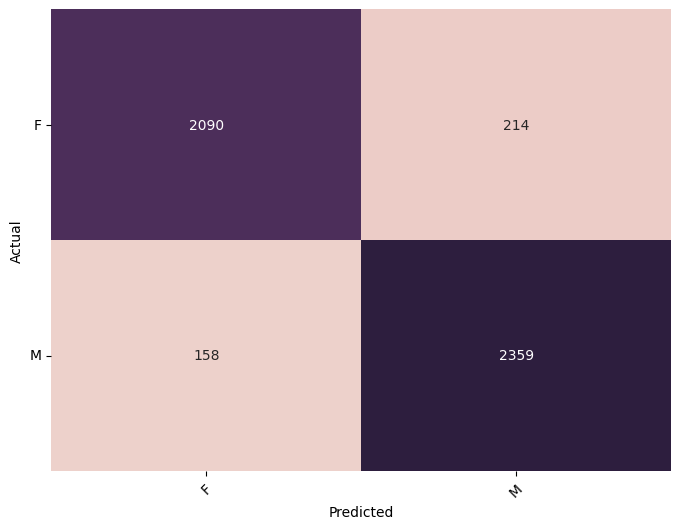

In [ ]:
race_labels =  ['F', 'M']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mx, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), cbar=False, xticklabels=race_labels, yticklabels=race_labels) 


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0)
plt.xticks(rotation=45)